In [1]:
from loca import print_date
print_date()

Last executed: 2019-06-15 00:42:32.123489 by jvano on r6i6n31


In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.data_catalog import load_daily_cmip_met_datasets, load_daily_historical_hydro_datasets
from loca.data_catalog import load_daily_cmip_hydro_datasets
from loca.data_catalog import load_daily_maurer_meteorology, load_daily_livneh_meteorology


# models = ['ACCESS1-0', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3', 'NorESM1-M']

# all 25:
models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4',
          'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
          'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
          'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

# models = ['CNRM-CM5']

hydro_met = 'hydro'  #or met

In [30]:
# client.restart()

In [3]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://10.148.10.15:57699 Dashboard: proxy/8787/status,Cluster Workers: 72 Cores: 288 Memory: 871.92 GB


In [4]:
def mean_max_precip(da):
    return da.resample(time='AS').max('time').mean('time')

def wet_day_fraction(da, thresh=0):
    nwet = da.where(da > thresh).count(dim="time")
    nday = da.sizes['time']
    return nwet / nday

In [5]:
def calc_and_write_stats(data, scen='hist'):
    if scen == 'hist':
        times = slice('1970', '1999')
# TO DO:  tried to add this, but it somehow gets called even when not obs (worked fine for obs, but then caused gcm runs to fail), did own obs call below for now.
# once joe back, can fix it.
#     elif 'obs' in scen: 
#         times = slice('1970', '1999')
#         if method == 'bcsd':
#             model = 'maurer'
#         elif 'loca' in method:
#             model = 'livneh'
    elif 'rcp' in scen:
        times = slice('2070', '2099')
    else:
        raise ValueError(period)
    try:
        da = data.sel(time=times).mean('time').load()
        da.to_netcdf(f'/glade/u/home/jvano/workdir/stats/mean_{hydro_met}_{method}_{scen}_{model}.nc')
    except:
        print('failed mean')
    
    try:
        da = mean_max_precip(data.sel(time=times)).load()
        da.to_netcdf(f'/glade/u/home/jvano/workdir/stats/annmax_{hydro_met}_{method}_{scen}_{model}.nc')
    except:
        print('failed max')
    
    try:
        da = wet_day_fraction(data.sel(time=times)).load()
        da.to_netcdf(f'/glade/u/home/jvano/workdir/stats/wetfrac_{hydro_met}_{method}_{scen}_{model}.nc')
    except:
        print('failed wdf')
        

In [6]:
def calc_and_write_stats_obs(data, scen='hist'):
    if scen == 'hist':
        times = slice('1970', '1999')
    elif 'obs' in scen:
        times = slice('1970', '1999')
        if method == 'bcsd':
            model = 'maurer'
        elif 'loca' in method:
            model = 'livneh'
    elif 'rcp' in scen:
        times = slice('2070', '2099')
    else:
        raise ValueError(period)
    try:
        da = data.sel(time=times).mean('time').load()
        da.to_netcdf(f'/glade/u/home/jvano/workdir/stats/mean_{hydro_met}_{method}_{scen}_{model}.nc')
    except:
        print('failed mean')
    
    try:
        da = mean_max_precip(data.sel(time=times)).load()
        da.to_netcdf(f'/glade/u/home/jvano/workdir/stats/annmax_{hydro_met}_{method}_{scen}_{model}.nc')
    except:
        print('failed max')
    
    try:
        da = wet_day_fraction(data.sel(time=times)).load()
        da.to_netcdf(f'/glade/u/home/jvano/workdir/stats/wetfrac_{hydro_met}_{method}_{scen}_{model}.nc')
    except:
        print('failed wdf')

In [7]:
hist_data = {}
rcp4_data = {}
rcp8_data = {}
obs_data = {}

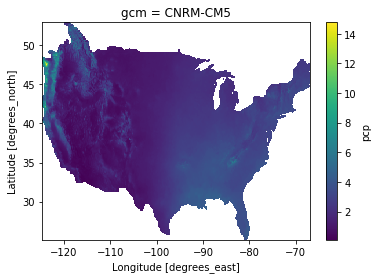

In [77]:
da.plot()

In [8]:
if hydro_met == 'met':
    obs_data  = {"bcsd": load_daily_maurer_meteorology(resolution='8th'), "loca": load_daily_livneh_meteorology(resolution='8th')}
    for method in ['bcsd', 'loca']: 
        calc_and_write_stats_obs(obs_data[method]['pcp'], scen='obs')
    for model in models:
        hist_data = load_daily_cmip_met_datasets('historical', models=[model], parallel=True)
        rcp4_data = load_daily_cmip_met_datasets('rcp45', models=[model], parallel=True)
        rcp8_data = load_daily_cmip_met_datasets('rcp85', models=[model], parallel=True)
        
        for method in ['loca', 'bcsd']:  #TODO make it more than just pcp
            calc_and_write_stats(hist_data[method]['pcp'], scen='hist')
            calc_and_write_stats(rcp4_data[method]['pcp'], scen='rcp45')
            calc_and_write_stats(rcp8_data[method]['pcp'], scen='rcp85')
    
if hydro_met == 'hydro':
    for model in models:
        hist_data = load_daily_cmip_hydro_datasets('historical', models=[model], parallel=True)
        rcp4_data = load_daily_cmip_hydro_datasets('rcp45', models=[model], parallel=True)
        rcp8_data = load_daily_cmip_hydro_datasets('rcp85', models=[model], parallel=True)
#         hist_data_obs = load_daily_historical_hydro_datasets('historical', models=[model], parallel=True)
        
        for method in ['loca', 'bcsd']:  #TODO make it more than just pcp
            calc_and_write_stats(hist_data[method]['total_runoff'], scen='hist')
            calc_and_write_stats(rcp4_data[method]['total_runoff'], scen='rcp45')
            calc_and_write_stats(rcp8_data[method]['total_runoff'], scen='rcp85')   
            
#     obs_data = load_daily_historical_hydro_datasets(resolution='8th')

load_daily_cmip_hydro_datasets
load_daily_loca_hydrology
load_daily_bcsd_hydrology
load_bcsd_dataset
load_daily_cmip_hydro_datasets
load_daily_loca_hydrology
load_daily_bcsd_hydrology
load_bcsd_dataset
load_daily_cmip_hydro_datasets
load_daily_loca_hydrology
load_daily_bcsd_hydrology
load_bcsd_dataset
load_daily_cmip_hydro_datasets
load_daily_loca_hydrology
load_daily_bcsd_hydrology
load_bcsd_dataset
load_daily_cmip_hydro_datasets
load_daily_loca_hydrology
load_daily_bcsd_hydrology
load_bcsd_dataset
load_daily_cmip_hydro_datasets
load_daily_loca_hydrology
load_daily_bcsd_hydrology
load_bcsd_dataset
load_daily_cmip_hydro_datasets
load_daily_loca_hydrology
load_daily_bcsd_hydrology
load_bcsd_dataset
load_daily_cmip_hydro_datasets
load_daily_loca_hydrology
load_daily_bcsd_hydrology
load_bcsd_dataset
load_daily_cmip_hydro_datasets
load_daily_loca_hydrology
load_daily_bcsd_hydrology
load_bcsd_dataset
load_daily_cmip_hydro_datasets
load_daily_loca_hydrology
load_daily_bcsd_hydrology
load_bcs

In [39]:
obs_data

{'bcsd': <xarray.Dataset>
 Dimensions:  (lat: 224, lon: 464, time: 23376)
 Coordinates:
   * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2013-12-31
   * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
   * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
 Data variables:
     t_mean   (time, lat, lon) float32 dask.array<shape=(23376, 224, 464), chunksize=(31, 224, 464)>
     pcp      (time, lat, lon) float32 dask.array<shape=(23376, 224, 464), chunksize=(31, 224, 464)>
 Attributes:
     CDI:                       Climate Data Interface version 1.9.4 (http://m...
     Conventions:               CF-1.4
     history:                   Mon Sep 17 15:07:20 2018: cdo -O remapcon,/gla...
     nco_openmp_thread_number:  1
     NCO:                       4.4.5
     CDO:                       Climate Data Operators version 1.9.4 (http://m...}

In [25]:
# DON'T USE WITH LOCA/BCSD ANALYSIS

wrf_gcm_map = {'ACCESS1-0': 'access13', 'CanESM2': 'canesm', 'CCSM4': 'cesm', 'CNRM-CM5': 'cnrm', 'MIROC5': 'miroc5', 'MRI-CGCM3': 'mri', 'NorESM1-M': 'noresm'}

def load_daily_icar_datasets(scen, models=None, **kwargs):
    
    fname = '/glade/p/ral/hap/trude/conus_icar/qm_data/{gcm}_{scen}_exl_conv.nc'
    fnames = [fname.format(gcm=wrf_gcm_map[gcm], scen=scen) for gcm in models]
    ds = xr.open_mfdataset(fnames, **kwargs)
    
    return ds

configs = ['AR_p', 'AR_puv', 'AR_uvq', 'PA_p', 'PA_puv', 'PA_uvq', 'PR_p', 'PR_puv', 'PR_uvq', 'PT_p']
def load_daily_gard_gutmann_datasets(scen, models=None, configs=None, **kwargs):
    
    fname = '/glade/u/home/gutmann/work/gard/paper_data/processed/gard_{gcm}_{scen}_{config}.nc'
    
    ds_list = []
    for config in configs:
        fnames = [fname.format(gcm=wrf_gcm_map[gcm], scen=scen, config=config) for gcm in models]
        ds_list.append(xr.open_mfdataset(fnames, **kwargs))
        
    return xr.concat(ds_list, dim=xr.Variable('config', configs)) 

In [21]:
# DON'T USE WITH LOCA/BCSD ANALYSIS

method = 'icar'
chunks = {'time': 183}
for model in models:
    hist_data[method] = load_daily_icar_datasets('hist', models=[model], chunks=chunks)
    rcp4_data[method] = load_daily_icar_datasets('rcp45', models=[model], chunks=chunks)
    rcp8_data[method] = load_daily_icar_datasets('rcp85', models=[model], chunks=chunks)
    
    calc_and_write_stats(hist_data[method]['pcp'], scen='hist')
    calc_and_write_stats(rcp4_data[method]['pcp'], scen='rcp45')
    calc_and_write_stats(rcp8_data[method]['pcp'], scen='rcp85')

/glade/u/home/jhamman/workdir/stats/mean_icar_hist_ACCESS1-0.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_rcp45_ACCESS1-0.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_rcp85_ACCESS1-0.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_hist_CanESM2.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_rcp45_CanESM2.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_rcp85_CanESM2.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_hist_CCSM4.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_rcp45_CCSM4.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_rcp85_CCSM4.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_hist_CNRM-CM5.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_rcp45_CNRM-CM5.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_rcp85_CNRM-CM5.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_hist_MIROC5.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_rcp45_MIROC5.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_rcp85_MIROC5.nc
/glade/u/home/jhamman/workdir/stats/mean_icar_hist_MRI-CGCM3

In [35]:
# DON'T USE WITH LOCA/BCSD ANALYSIS

wrf_gcm_map = {'ACCESS1-0': 'access13', 'CanESM2': 'canesm', 'CCSM4': 'ccsm4', 'CNRM-CM5': 'cnrm', 'MIROC5': 'miroc5', 'MRI-CGCM3': 'mri', 'NorESM1-M': 'noresm'}
gcms = ['ACCESS1-0', 'MIROC5', 'MRI-CGCM3', 'NorESM1-M', ]
# 'CNRM-CM5', 'CanESM2' # broken in GARD

method = 'gard'
chunks = {'time': 183}
for model in models:
    try:
        hist_data[method] = load_daily_gard_gutmann_datasets('hist', models=[model], configs=configs, chunks=chunks)
        rcp8_data[method] = load_daily_gard_gutmann_datasets('rcp85', models=[model], configs=configs, chunks=chunks)
    except FileNotFoundError:
        print('model failed')
        continue
    calc_and_write_stats(hist_data[method]['pcp'], scen='hist')
    calc_and_write_stats(rcp8_data[method]['pcp'], scen='rcp85')

/glade/u/home/jhamman/workdir/stats/mean_gard_hist_ACCESS1-0.nc
/glade/u/home/jhamman/workdir/stats/mean_gard_rcp85_ACCESS1-0.nc
failed mean
failed max
failed wdf
/glade/u/home/jhamman/workdir/stats/mean_gard_rcp85_CanESM2.nc
/glade/u/home/jhamman/workdir/stats/mean_gard_hist_CCSM4.nc
/glade/u/home/jhamman/workdir/stats/mean_gard_rcp85_CCSM4.nc
model failed
/glade/u/home/jhamman/workdir/stats/mean_gard_hist_MIROC5.nc
/glade/u/home/jhamman/workdir/stats/mean_gard_rcp85_MIROC5.nc
/glade/u/home/jhamman/workdir/stats/mean_gard_hist_MRI-CGCM3.nc
/glade/u/home/jhamman/workdir/stats/mean_gard_rcp85_MRI-CGCM3.nc
/glade/u/home/jhamman/workdir/stats/mean_gard_hist_NorESM1-M.nc
/glade/u/home/jhamman/workdir/stats/mean_gard_rcp85_NorESM1-M.nc


In [28]:
hist_data

{'icar': <xarray.Dataset>
 Dimensions:    (lat: 224, lon: 464, time: 20073)
 Coordinates:
   * time       (time) datetime64[ns] 1951-01-02T23:00:00 ... 2005-12-30T23:00:00
   * lat        (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
   * lon        (lon) float64 -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
 Data variables:
     pcp        (time, lat, lon) float32 dask.array<shape=(20073, 224, 464), chunksize=(183, 224, 464)>
     t_mean     (time, lat, lon) float32 dask.array<shape=(20073, 224, 464), chunksize=(183, 224, 464)>
     t_range    (time, lat, lon) float32 dask.array<shape=(20073, 224, 464), chunksize=(183, 224, 464)>
     elevation  (lat, lon) float64 dask.array<shape=(224, 464), chunksize=(224, 464)>
     mask       (lat, lon) int64 dask.array<shape=(224, 464), chunksize=(224, 464)>
     t_max      (time, lat, lon) float32 dask.array<shape=(20073, 224, 464), chunksize=(183, 224, 464)>
     t_min      (time, lat, lon) float32 dask.array<shape=(20073, 2